In [75]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import torchvision.transforms as transforms
import torchvision

# class Reshape(nn.Module):
#     def forward(self,x):
#         return x.view(-1,3,224,224)

# 定义一个残差块
class Residual(nn.Module):
    def __init__(self,input_channels,num_channels,
                  use_lxlconv = False,strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels,num_channels,
                              kernel_size=3,padding=1,stride=strides)
        self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
        if use_lxlconv:
            self.conv3 = nn.Conv2d(input_channels,num_channels,
                                   kernel_size=1,stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self,X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [76]:
# 查看这个残差块的输入输出情况，此时它的输入和输出是一致的
blk = Residual(3,3)
X = torch.rand(4,3,6,6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [77]:
# 增加输出通道数，减半输出的高和宽
blk = Residual(3,6,use_lxlconv=True,strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [78]:
# 前三层: 卷积->批量归一化->最大池化
# 开始创建ResNet模型
b1 = nn.Sequential(nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
                  nn.BatchNorm2d(64),nn.ReLU(),
                  # nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
                  )

def resnet_block(input_channels,num_channels,num_residuals,first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels,num_channels,
                                use_lxlconv=True,strides=2))
        else:
            blk.append(Residual(num_channels,num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3 = nn.Sequential(*resnet_block(64,128,2))
b4 = nn.Sequential(*resnet_block(128,256,2))
b5 = nn.Sequential(*resnet_block(256,512,2))

net = nn.Sequential(b1,b2,b3,b4,b5,
                    nn.AdaptiveAvgPool2d((1,1)),        # 全局平均汇聚层
                    nn.Flatten(),nn.Linear(512,10))

In [79]:
X = torch.rand(size=(1,3,32,32))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 32, 32])
Sequential output shape:	 torch.Size([1, 64, 32, 32])
Sequential output shape:	 torch.Size([1, 128, 16, 16])
Sequential output shape:	 torch.Size([1, 256, 8, 8])
Sequential output shape:	 torch.Size([1, 512, 4, 4])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [80]:
transform = transforms.Compose(
    [# transforms.Resize(224),
     transforms.ToTensor(),
     transforms.ColorJitter(brightness=0.3,contrast=0,saturation=0,hue=0),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# 在构建数据集的时候指定transform，应用定义好的transform
cifar_train = torchvision.datasets.CIFAR10(root='./data',train=True,
                                          download=True,transform = transform)
cifar_test = torchvision.datasets.CIFAR10(root='./data',train=False,
                                          download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(cifar_train,batch_size=32,shuffle=True)
testloader = torch.utils.data.DataLoader(cifar_test,batch_size=32,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


start training
1 100 1.7133196485042572
1 200 1.664361047744751
1 300 1.574158548116684
1 400 1.5625437664985657
1 500 1.4325524574518205
1 600 1.3766448640823363
1 700 1.3252989768981933
1 800 1.2291377252340316
1 900 1.1886386519670487


KeyboardInterrupt: 

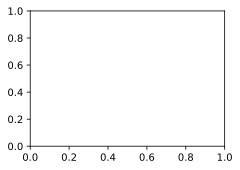

In [82]:
import torch.optim as optim
print('start training')
animator = d2l.Animator(xlabel='epoch', xlim=[1, 30],
                        legend=['train loss', 'train acc'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.01,momentum=0.9)
for epoch in range(10):
    # 记录每100个batch的平均loss
    loss100 = 0.0
    correct = 0
    n = 0
    total = 0.0
    sumLoss = 0.0
    for i,data in enumerate(trainloader):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        loss100 += loss.item()
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        n += 1
        sumLoss += loss
        if i % 100 == 99:
            print(epoch + 1,i + 1,loss100 / 100)
            loss100 = 0.0
    animator.add(epoch+1,(sumLoss.item()/n,correct/total))
print('done training')